# Execute basic operations on the tree

Hyperiax is designed for fast and easy-to-use tree-level executions. In this notebook, you will know the general workflow, including defining your operations, executing them using Hyperiax's engine, visualize the results, and a simple way to integrate all the parts using Hyperiax's prebuilt modules.

For better illustration, we shall use an concrete example in phylogenetic analysis: estimating inner nodes of a phylogenetic tree, given:
- observations of the leaf nodes
- knowledge of the tree topology, including number of nodes, the edges connecting them and the edge lengths

This is a basic problem in the field of _phylogenetic comparative methods_. We may be particularly interested in the root node estimation, which can be interpreted as the phylogenetic mean of the observations, where we shall use a very simple estimator the inner nodes: **mean estimator**, that is, any inner node will be estimated as the mean of its children weighted by its edge length:
$$
\hat{x} = \sum^k_{i=1} \frac{1}{w_i}\cdot c_i
$$
where $\hat{x}$ is the estimation of node $x$, $w_i$ is the edge length of the $i$-th child node, and $c_i$ is the child's value. We set all the node values are 2-dimensional vectors, which allows for nicer visualizations, but you can of course use Hyperiax to deal with other high-dimensional data.

In practice, we create trees from real data. However, in this notebook, we are not going to study a real-life example. Instead, we will create a hypothetical tree, and of course, we can manually assign values to each node. But we will show a faster method: simulating the tree from the root node, based on the Brownian motion model. Specifically, an edge of length $T$ corresponds to a Brownian motion running for a duration of $T$. 

**Content of the notebook**
- Create the tree with a chosen topology and simulate its node values, based on the Brownian motion model
- Estimate inner nodes based on the simulated tree
- Compute the estimations more conveniently using `prebuilts` modules

In [1]:
import hyperiax
from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda
from hyperiax.models.functional import pass_up
from hyperiax.tree.topology import symmetric_topology
from hyperiax.tree import HypTree
from hyperiax.plotting import plot_tree_text, plot_tree_2d_scatter

import jax
from jax import numpy as jnp
from jax.random import PRNGKey, split
from matplotlib import pyplot as plt

## Simulate the tree (downwards)

Recall briefly last notebook, where we learn that a `topology` is needed for Hyperiax to create the tree, this `topology` contains no actual data, and only serves as a representation of the data structure we intend to work on.

We first create a symmetric tree with `height=4` and `degree=3`, which means the tree will have `4+1=5` layers, and each node has `3` children.

In [2]:
topology = symmetric_topology(height=3, degree=3)
plot_tree_text(topology)

                                                                 None
                     ┌────────────────────────────────────────────┼────────────────────────────────────────────┐
                    None                                         None                                         None                    
      ┌──────────────┼──────────────┐              ┌──────────────┼──────────────┐              ┌──────────────┼──────────────┐       
     None           None           None           None           None           None           None           None           None     
 ┌────┼────┐    ┌────┼────┐    ┌────┼────┐    ┌────┼────┐    ┌────┼────┐    ┌────┼────┐    ┌────┼────┐    ┌────┼────┐    ┌────┼────┐  
None None None None None None None None None None None None None None None None None None None None None None None None None None None


The topology meets our expectation. Now we need to specify which kind of data we intend to store in the tree. Hyperiax allows for fast computation using any backend supported by _JAX_, and if the operations are suitable, _JAX_ will automatically remove all the computation to the GPUs (if available) and runs them at an extraordinary speed. Therefore, all the data store in the `HypTree` is stored in the format of `jax.numpy.ndarray`, which is the _Numpy_-like array with _JAX_ backend. To assign the data, we need to let Hyperiax know the shape of coming data first, which is for initializing buffer. But don't worry, all you need to do is just to pass the shape as tuples, and Hyperiax will take over the rest.

In our case, we need to assign three properties to each node:
- `edge_length`: as we use in the last notebook, we will use it to determine the scale of Brownian motions along the edges, with shape of `(1,)`
- `value`: the data value stored in each node, in this case, is a 2-d vector with shape of `(2, )`
- `noise`: the noise (for example, from the observations) in each node, with the same shape as `value`

In [3]:
tree = HypTree(topology)
tree.add_property('noise', shape=(2,))
tree.add_property('edge_length', shape=(1,))
tree.add_property('value', shape=(2,))

When calling `add_property()` method of `HypTree`, Hyperiax will initialize the a contiguous buffer in the memory with given shapes and number of nodes, with the BFS order in `tree.data`, and all the actual values are initialized to `0`.

We first set the edge lengths to be exponentially decaying with the depth, like we did in the previous notebook

In [4]:
tree.data['edge_length'] = jnp.exp(-jnp.log(2) * tree.node_depths)

We might also need to deal with some randomness, for example, the `noise` of each node. With the help of contiguous buffer created by Hyperiax, we can directly sample values for the entire tree, instead of do it one node at a time. This should be the preferred method, except the underlying distribution is node-dependent.

Now, we can do the same for the 2-dimensional values that we intend to store in `noise`:

In [5]:
key = PRNGKey(0)
key, subkey = split(key)
tree.data['noise'] = jax.random.normal(subkey, shape=tree.data['noise'].shape)

After we initialize the tree, we need to define a function that runs downwards to simulate the Brownian motions along the edges. We shall call it `down` function for short in the result of the notebook. Generally, a `down` function should have the following features:
- Defined on a edge $(u, v)$, where $u$ is the source node and $v$ is the target node.
- Used to compute the new value of $v$ based on the current states (can only depends on $u$ or $v$ or both)

With this in mind, go back to our Brownian case. The goal of our Brownian simulation is to simulate all the node values except the root, and the value of every node is sample from a Brownian motion starts from its parent node and runs for the time of the distance from the root to the evaluated node. If we denote the edge length as $T$, the value of evaluated root $v$ should follow the distribution of $\mathcal{N}(v; u, T\cdot\mathbf{I})$. In practice, $v = u + \sqrt{T}\cdot\epsilon$, where $\epsilon\sim\mathcal{N}(0,\mathbf{I})$ and can be generated using `jax.random.normal()` for example, or we can just use our previously defined `noise`.

Before we start to define the `down` function, we need to know a bit about how Hyperiax treats the `down` function: In Hyperiax, functions on a tree always consider the _current_ node. When referring to properties such as `noise`, it means the `noise` stored in the _current_ node. To define custom operations on a tree, we can query the necessary data within nodes by specifying parameter names. In this case, we need both the `noise` and the `edge_length` in the _current_ node. Additionally, we need the result of calculations from the parent node. In hyperiax, values stored in the _parent_ node are prefixed with `parent_`. For this computation, we need `parent_value` (the result of the computation in the parent node).

Now we are ready to define the `down` function. The implementation of the `down` function involves the following steps:

1. **Extract the necessary parameters**:
    - `noise`: the noise value in the _current_ node.
    - `edge_length`: the edge length stored in the _current_ node (this is by convention the length of the edge connecting the _current_ and _parent_ node)
    - `parent_value`: the result of the computation in the _parent_ node.

2. **Compute the new value for the child node**:
    - Calculate the new value as `sqrt(edge_length) * noise + parent_value`.

3. **Return the new value**:
    - Return a dictionary specifying the `value` parameter to overwrite in the child node $v$. Values that are not being changed, such as `edge_length`, can be omitted.

Hyperiax will greedily distribute your workloads, using vectorization among other techniques. This means that any `down` function is expected to work on _batched_ data. In our example, the input shapes will be as follows;

- `noise`: `(b, 2)`.
- `edge_length`: `(b, 1)`.

Similarly, we need to return a _batched_ output, in this case `value`, should have the shape `(b, 2)`, where `b` is some batch size determined by hyperiax.

If the concept of batching seems uncomfortable to you, we highly recommend using [`jax.vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) which can do the batching for you automatically.

In [6]:
@jax.jit
def down(noise, edge_length,parent_value, **args):
    return {'value': jnp.sqrt(edge_length) * noise + parent_value}

Here, we set the root value to be the `noise` we sampled. All the data is stored in BFS order in the buffers, this means that the root is always the first element.

In [7]:
tree.data['value'] = tree.data['value'].at[0].set(tree.data['noise'][0])

Now we create both an **executor** and a **model**. The **model** object contains all user code related to the operations we wish to run on a tree. The **executor** object schedules execution within the tree, and is in charge of setting the data in the correct format, as well as batching things together and making sure everything runs in the correct order.

You are welcome to define your operations as an entire class, in cases where a constructor is needed. In this example we use the anonymous **lambda models** in `hyperiax.models.lambdamodels.py`, which enables you to pass tree operations as arguments, such that they are ready to be executed on a tree directly.

In [8]:
downmodel = DownLambda(down_fn=down)

We have now created a `downmodel`, specified by the `down` function that will generate Brownian motion samples on a tree. The only thing left to do is give this **model** to an executor, which will run the code in the correct order on the tree. In this case we use the `OrderedExecutor`, since order is important for our operation. This executor will work on models going in either the up or down direction on a tree.

In [9]:
exe = OrderedExecutor(downmodel)

With these objects created, we can now run our `down` function on the tree! Be careful as these operations are **INPLACE**. Because of this, we reccomend [idempotent](https://en.wikipedia.org/wiki/Idempotence) operations like here, where the result is stored in `value`, instead of overwriting `noise`(notice how this would give a different result for each execution).

In [10]:
exe.down(tree)

Besides topology visualizations, Hyperiax also provides avenues of displaying the underlying data in the tree. When dealing with $2$ dimensional vectors, we can perform a classic scatter plot, but with the tree topology overlaid.

Note that passing in a pyplot axis object is optional, if you do not wish to use your own, then it can be omitted.

Using these two plots, we can see how the `down` function infact seems to correlate our nodes!

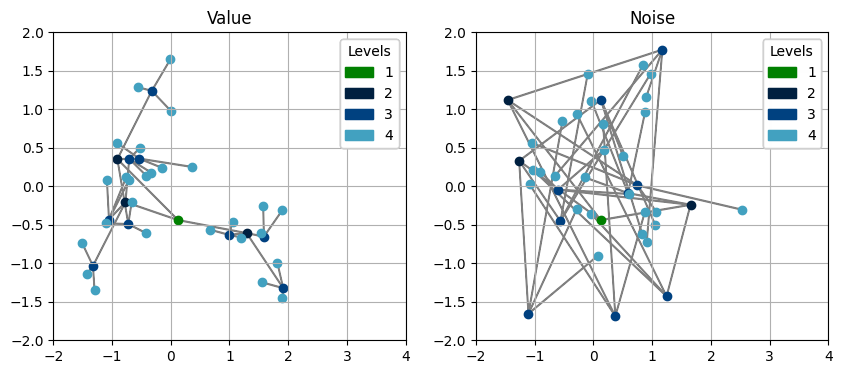

In [11]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
for a in ax:
    a.set_xlim(-2, 4)
    a.set_ylim(-2, 2)
plot_tree_2d_scatter(tree, 'value', ax=ax[0])
ax[0].set_title('Value')
plot_tree_2d_scatter(tree, 'noise', ax=ax[1])
ax[1].set_title('Noise');

The green node represents the root, and the light blue nodes represent the leafs.

## Estimate the inner nodes (upwards)

So far, we assume we know the value of root, together with the model that runs from top to bottom. However, in most of the real cases, we know about the leaf nodes, and want to inference the root and inner nodes. In phylogenetics, the leaf nodes are the species we observe at current time, and the root and inner nodes represents their ancestors.

Now we going to mask all the data on the inner nodes of our simulated tree, and only keeps the leaf nodes. To do this, `HypTree` has a boolean mask that indicates whether or not a node is a obtainable leaf via `tree.is_leaf`. Therefore, we can add another property `estimated_value` to the tree, with the same shape as `value`, and initialized as `0`. Then we index the leaf nodes by slicing through `is_leaf` and manually set them to be the simulated leaf `value`: 

In [12]:
tree.add_property('estimated_value', shape=(2,))
leaf_data = tree.data['value'][tree.is_leaf]
tree.data['estimated_value'] = tree.data['estimated_value'].at[tree.is_leaf].set(leaf_data)

We have all the observations on the leaf nodes, we want to estimate the nodes above. The direction is upward, from bottom to top. Thus, we need a `up` function just like the `down` function we defined before. But unlike the downward pass, where the message is passing through a one-to-one pair $(u, v)$, the upward pass will aggregate all the information from child nodes to the parent node, so it is a many-to-one correspondence. Therefore beside `up` function, we need to define another two addons to facilitate Hyperiax to handle this: `reductions` parameter and `transform` function:
* The `reductions` parameter of the `UpLambda` class, determines how each property should be reduced when multiple are incoming from the _child_ nodes. In this case we have `sum` for both arguments. This means that after a message is sent from each child toward its parent, each property is first summed before the `transform` operation in the _parent_.
* The `transform` function processes the reduced incoming messages of the _child_ nodes, and treats the receiving node of the messages as the _current_ node. This means that we need to use the prefix `child_` when getting the reduced values of the children.
* The `up` function then takes the value in a _current_ node, and forms a message that is passed toward its _parent_.

In [13]:
def up(estimated_value, edge_length, **kwargs):
    return {'weighted_value': estimated_value/edge_length, 
            'inverse_edge_length':1/edge_length}
    
def transform(child_weighted_value,child_inverse_edge_length, **kwargs):
    return {'estimated_value': child_weighted_value/child_inverse_edge_length}

upmodel = UpLambdaReducer(up, 
                          transform, 
                          reductions={
                            'weighted_value': 'sum', 
                            'inverse_edge_length': 'sum'
                    })

Since upward pass is more complicated than the downward pass, it is worthy to explain it more here. We first summarize what we expect about `up`, `reduction` and `transform`:
- **Up Operation (`up` function)**:
   - **Purpose**: To generate a message at _each_ node that will be passed to its parent.
   - **Inputs**: Values specific to the current node.
   - **Outputs**: A message containing the processed values to be sent to the parent node.

- **Reduction (`reductions` parameter)**:
   - **Purpose**: To aggregate messages from _multiple_ child nodes.
   - **Inputs**: Messages from the child nodes.
   - **Outputs**: A single aggregated message that combines the values from all child nodes using a specified reduction method (e.g., sum).

- **Transform Operation (`transform` function)**:
   - **Purpose**: To process the aggregated message at the _parent_ node.
   - **Inputs**: Aggregated messages from the child nodes aswell as the values in the _current_ node.
   - **Outputs**: A transformed value for the parent node.

Then we can explain the above code in details:

**1. Up Operation (`up` function)**

The `up` function takes the value at the current node and forms a message that will be passed to the parent node. 

When hyperiax executes functions on a tree, it always has a sense of the _current_ node. In hyperiax terminology, when referring to a specific property, such as `estimated_value`, it means the `estimated_value` stored in the _current_ node.

- **Parameters**:
  - `estimated_value`: The value associated with the current node.
  - `edge_length`: The length of the edge connecting the current node to its parent.
  - `**kwargs`: Any additional arguments that might be needed.
- **Returns**: A dictionary with two properties:
  - `weighted_value`: Calculated as `estimated_value / edge_length`.
  - `inverse_edge_length`: Calculated as `1 / edge_length`.

In this case, with $w_i=1/l_i$ with $l_i$ being the edge length in node $i$. We can write the inner node estimation $p$ as a sum over children $c_i$

$$p=\frac{1}{\sum w_i}\sum c_iw_i$$

The key is to observe that we can compute $\sum w_i$ and $\sum c_iw_i$ independently, where we use the sum as a reduction and $w_i$ and $w_ic_i$ are the messages being passed up

**2. Transform Operation (`transform` function)**

The `transform` function processes the aggregated message at the parent node. It uses the reduced values from the child nodes to compute a new value for the current (parent) node.

- **Parameters**:
  - `child_weighted_value`: The aggregated `weighted_value` from all child nodes.
  - `child_inverse_edge_length`: The aggregated `inverse_edge_length` from all child nodes.
  - `**kwargs`: Any additional arguments that might be needed.
- **Returns**: A dictionary with one property:
  - `estimated_value`: Calculated as `child_weighted_value / child_inverse_edge_length`.

**3. Reduction (`reductions` parameter)**

The reduction step determines how to combine multiple messages received from child nodes. In this example, we use the sum operation for both `weighted_value` and `inverse_edge_length` properties.

- **`weighted_value`**: The messages' `weighted_value` properties from all child nodes are summed.
- **`inverse_edge_length`**: The messages' `inverse_edge_length` properties from all child nodes are summed.

After understanding what all these are used for, we can put them all together and warp them by the **lambda model** as we did for the downward pass. To set up the upward pass, we define an `UpLambda` model with the `up` and `transform` functions, and the specified reductions.

- **`UpLambda`**: Initializes the upward pass model with the `up` and `transform` functions and the reduction rules.
- **`OrderedExecutor`**: Executes the upward pass using the defined model.

This setup ensures that values propagate correctly from the leaves to the root, are aggregated at each step, and transformed to provide the final values at each node. Then we can execute the computation and let Hyperiax take over all the rest.

In [14]:
upward_exe = OrderedExecutor(upmodel)
upward_exe.up(tree)
%timeit upward_exe.up(tree)

13.3 μs ± 178 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


We can of course visualize the estimated results:

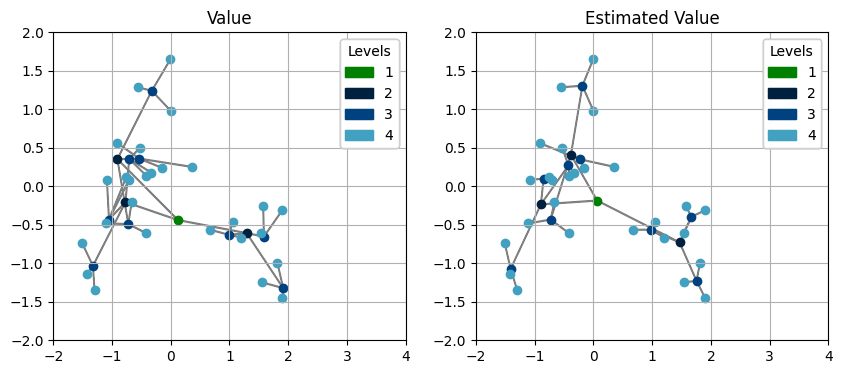

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))
for a in ax:
    a.set_xlim(-2, 4)
    a.set_ylim(-2, 2)
plot_tree_2d_scatter(tree, 'value', ax=ax[0])
ax[0].set_title('Value')
plot_tree_2d_scatter(tree, 'estimated_value', ax=ax[1])
ax[1].set_title('Estimated Value');

We can see that the estimated values follow the same distribution as the simulated ones, which is reasonable since we used the same model for downward and upward passes.

**Getting around with `reductions`**

We also allow for a simpler interface in the up-direction at a cost. If your tree has a constant or zero number of children for all nodes, and you are willing to do some upfront work `(precompute_child_gathers=True)`, then you can get around the reduce operation by simply specifying an `up` function that can access data in child nodes and the current node. The returned values are to be set in the current node.

The way it handles children is a bit different. In our example, our `value`s in the children are 2 dimensional vectors, and since each node in our topology has exactly `3` or `0` children, we say that the base of the tree is `3`. We can now query the child values by giving `child_estimated_value` as a parameter to our up function. This will have the shape `[batch, base, dimension]` where in our case `batch` is determined by hyperiax, `base=3` from the tree, and `dimension=2` because we are working in 2d. We now need to aggregate these such that we return something with the shape `[batch, dimension]` as the estimated value. In this example, we do it by a weighted mean, using the edge lengths as weights.

In [16]:
pre_tree = HypTree(topology, precompute_child_gathers=True)
pre_tree.data = tree.data.copy()

In [17]:
# use precomputed child gathers to accelerate the upward pass
def up(child_estimated_value, child_edge_length, **kwargs):
    inv_el = 1/child_edge_length
    normalizer = inv_el.sum(axis=1)

    return {'estimated_value': jnp.einsum('bcd,bc1->bd', child_estimated_value, inv_el)/normalizer}

In [18]:
upmodel = UpLambda(up_fn=up)
upmodelexe = OrderedExecutor(upmodel)
res = upmodelexe.up(pre_tree)
%timeit upmodelexe.up(pre_tree)
print((pre_tree.data['estimated_value'] == tree.data['estimated_value']).all())

10.2 μs ± 298 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
True


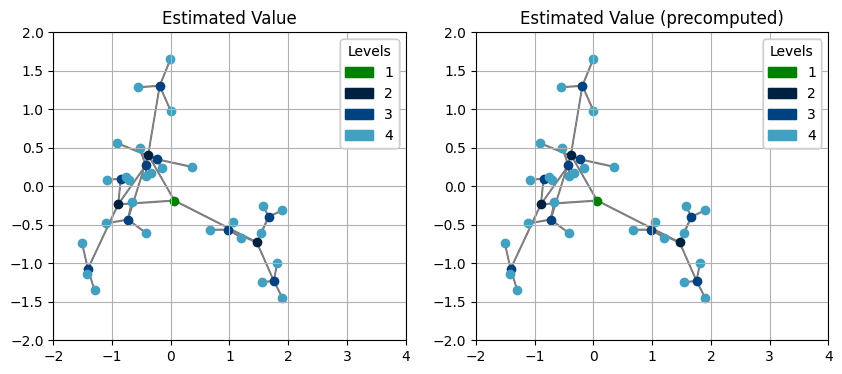

In [19]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
for a in ax:
    a.set_xlim(-2, 4)
    a.set_ylim(-2, 2)
plot_tree_2d_scatter(tree, 'estimated_value', ax=ax[0])
ax[0].set_title('Estimated Value')
plot_tree_2d_scatter(pre_tree, 'estimated_value', ax=ax[1])
ax[1].set_title('Estimated Value (precomputed)');

We can see the precomputed tree gets exactly the same results as doing it in the normal way, but runs 25% faster (9.64μs compared to 12.9μs). However, such precomputation is only available when the parents have constant number of children, while in a more general case, the previous way of defining `up` is recommended.

## Using `prebuilts` to finish them all in once

Alternatively, we can use the cool `hyperiax.models.prebuilts` to do the same computations as above, but more conveniently!

In [20]:
from hyperiax.models.prebuilts import PhyloMeanModel

The `PhyloMeanExecutor` expects leaf nodes to all contain a field called `estimated_value`. Since we already know the exact values here, we can simply set them directly

In [21]:
pme = PhyloMeanModel()
prebuilt_exe = OrderedExecutor(pme)

In [22]:
prebuilt_exe.up(tree)

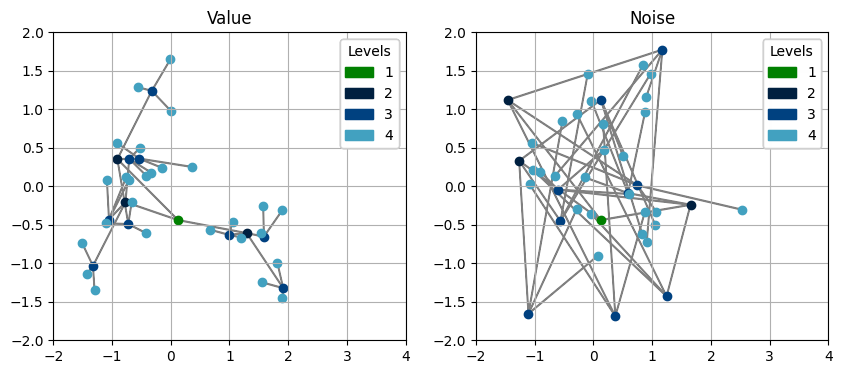

In [23]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
for a in ax:
    a.set_xlim(-2, 4)
    a.set_ylim(-2, 2)
plot_tree_2d_scatter(tree, 'value', ax=ax[0])
ax[0].set_title('Value')
plot_tree_2d_scatter(tree, 'noise', ax=ax[1])
ax[1].set_title('Noise');

In this case, we don't need to care about defining `up`, `reductions` or `transform` anymore, just run `prebuilt_exe.up()`, which is super easy and cool!

## Summary
Now you know how to define a basic mean estimation operation in Hyperiax, and execute it downwards or upwards. In the next notebook, we will show a more complicated, but also very interesting task in biological morphometry: aligning two species' shapes on the phylogenetic tree, and how Hyperiax can handle this in an easy and efficient way.